In [14]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

# scikit learn
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
df = None
file_path = Path('/home/device1/predictive_ml/datasets/diabetes_prediction_dataset.csv')
if file_path.exists():
    df = pd.read_csv(file_path)

In [11]:
# Seems to be no missing values
# 'diabetes' is the target class

df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [32]:
# No missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

## Data exploration

In [33]:
# Really no difference between bmi for diabetes
df.groupby('diabetes').agg({'bmi' : ['median', 'max']}).reset_index()

diabetes    bmi       
           median    max
0        0  27.32  95.69
1        1  29.97  88.72

In [34]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [38]:
# Blood glucose shows a significant difference for diabetes patients
df.groupby('diabetes').agg({'blood_glucose_level' : ['median', 'max']}).reset_index()

diabetes blood_glucose_level     
                        median  max
0        0               140.0  200
1        1               160.0  300

In [45]:
# By age shows that elder people get diabetes more
x = df.groupby('diabetes').agg({'age' : ['median', 'max']}).reset_index()
x.columns = ['diabetes', 'age_median', 'age_max']
x

,diabetes,age_median,age_max
0,0,40.0,80.0
1,1,62.0,80.0


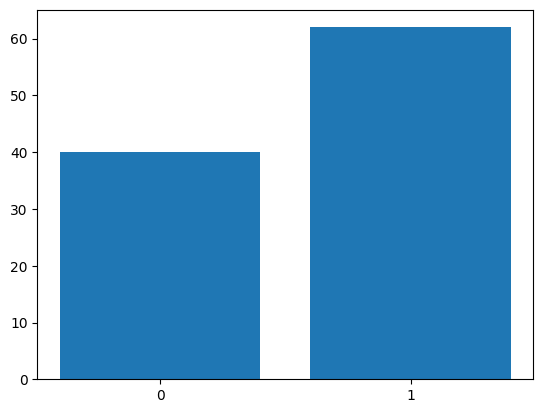

In [50]:
plt.bar([0,1], x['age_median'])
plt.xticks([0,1])
plt.show()

### Outlier Detection

In [60]:
df['gender'].dtype == 'int'

False

In [76]:
def find_outliers(feature_name : None):
    """."""
    try:
        if bool(feature_name) == False or feature_name not in df.columns:
            raise ValueError(f'incorrect feature name {feature_name} given')
            
        if df[feature_name].dtype == 'int' or df[feature_name].dtype == 'float':
            percentile_25 = float(df['blood_glucose_level'].describe()['25%'])
            percentile_75 = float(df['blood_glucose_level'].describe()['75%'])
            IQR = percentile_75 - percentile_25 
            upper_bound = percentile_75 + 1.5 * IQR
            lower_bound = percentile_25 - 1.5 * IQR
            idx_lst = df[df['blood_glucose_level'] > upper_bound].index
            return 'success', feature_name, idx_lst
    
    except ValueError as val_err:
        return val_err, None, None
    
    except Exception as e:
        return str(e), None, None
    

In [77]:
msg, feature_name, idx_lst = find_outliers('blood_glucose_level')
print(msg)

success


In [84]:
df.loc[idx_lst, 'blood_glucose_level']

38       260
94       300
104      280
125      280
142      300
146      280
199      300
361      280
414      260
518      280
609      260
650      260
746      300
936      300
944      280
1005     280
1044     300
1082     300
1121     300
1135     280
1170     260
1218     300
1220     300
1274     260
1332     260
1360     300
1365     300
1391     280
1394     260
1571     280
1621     280
1723     260
1737     300
1765     280
1798     260
1825     260
1957     300
2096     280
2169     280
2176     260
2294     300
2305     280
2316     300
2321     260
2360     300
2421     300
2481     260
2518     260
2520     280
2534     300
2538     300
2539     260
2541     260
2557     300
2561     300
2596     280
2614     280
2622     280
2677     280
2708     300
2726     280
2733     300
2861     280
2902     260
2930     300
2965     260
3022     260
3240     300
3252     280
3316     280
3368     260
3394     260
3427     300
3433     260
3574     300
3629     280
3759     260

In [67]:
lower_bound = float(df['blood_glucose_level'].describe()['25%']) 
upper_bound = float(df['blood_glucose_level'].describe()['75%']) 
df[df['blood_glucose_level'] > upper_bound].shape

(18589, 9)

In [68]:
df[df['blood_glucose_level'] > upper_bound].index

Index([    6,    13,    14,    16,    26,    30,    37,    38,    39,    40,
       ...
       99937, 99938, 99941, 99942, 99949, 99957, 99962, 99977, 99979, 99992],
      dtype='int64', length=18589)

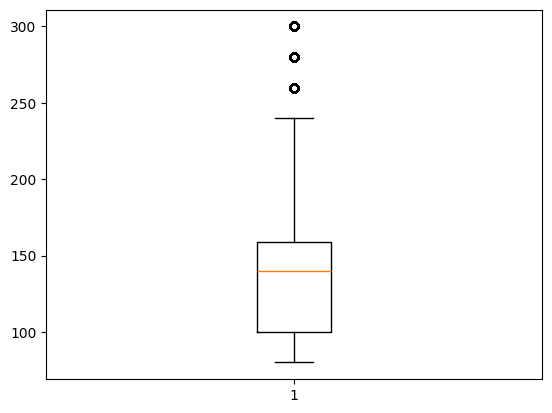

In [37]:
plt.boxplot(df['blood_glucose_level'])
plt.show()

In [24]:
# Imbalanced classification problem
df['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

In [53]:
# higher diabetes is seen in cases where the person also heart disease
df.groupby(['diabetes', 'heart_disease'])['bmi'].count()

diabetes  heart_disease
0         0                88825
          1                 2675
1         0                 7233
          1                 1267
Name: bmi, dtype: int64

In [89]:
df.head(4)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0


In [90]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [95]:
# Cannot understand the labels for this categorical data
df.groupby(['smoking_history', 'diabetes'])['age'].count()

smoking_history  diabetes
No Info          0           34362
                 1            1454
current          0            8338
                 1             948
ever             0            3532
                 1             472
former           0            7762
                 1            1590
never            0           31749
                 1            3346
not current      0            5757
                 1             690
Name: age, dtype: int64

In [96]:
df.sample(4)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
86682,Male,72.0,1,0,former,27.32,4.5,160,0
17291,Male,64.0,0,0,never,26.93,6.6,159,0
2655,Female,7.0,0,0,No Info,25.46,6.5,85,0
31528,Female,46.0,0,0,never,40.82,8.2,240,1


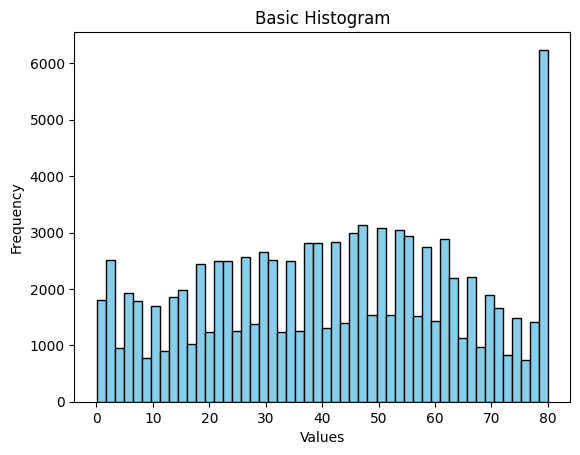

In [98]:
# Checking the values for age
# Plotting a basic histogram for age
# Right skewed data # Plotting a basic histogram
plt.hist(data, bins=30, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')

# Display the plot
plt.show()
plt.hist(df['age'], bins=50, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')

# Display the plot
plt.show()

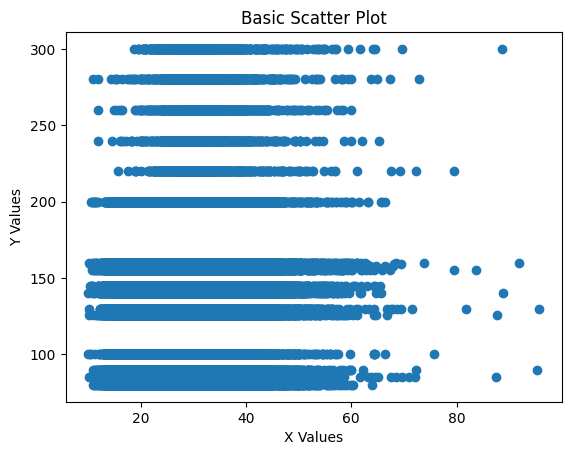

In [87]:
plt.scatter(df['bmi'], df['blood_glucose_level'])
plt.title("Basic Scatter Plot")
plt.xlabel("X Values")
plt.ylabel("Y Values")
plt.show()

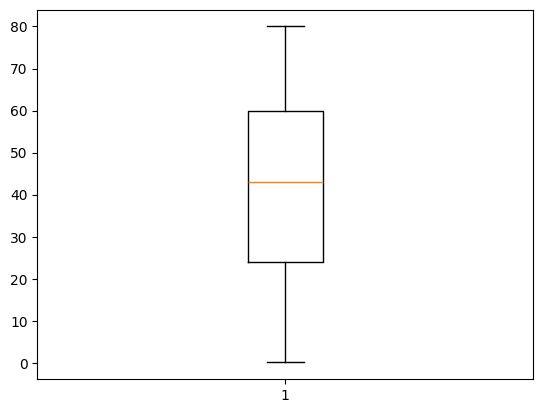

In [17]:
plt.boxplot(df['age'])
plt.show()

### Feature Selection